In [1]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
def vis(t: torch.Tensor, label=''):
    data = t.detach().numpy()
    data = data.round(3)
    df = pd.DataFrame(columns=data) if t.ndim == 1 else pd.DataFrame(data)
    df.columns.name = label+':'
    # df = df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'normal')]}])
    display(df)

vis(torch.rand(7))

:,0.200,0.884,0.234,0.366,0.051,0.809,0.638


In [3]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)} words')
print(f'min word length: {min(len(w) for w in words)}')
print(f'max word length: {max(len(w) for w in words)}')
print(words[:10])

32033 words
min word length: 2
max word length: 15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

vis(Xtr)
vis(Ytr)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


:,0,1,2
0,0,0,0
1,0,0,25
2,0,25,21
3,25,21,8
4,21,8,5
...,...,...,...
182620,0,8,15
182621,8,15,12
182622,15,12,4
182623,12,4,1


:,25,21,8,5,14,7,0,4,9,15,...,5,12,0,8,15,12,4,1,14,0


In [6]:
train_ds = TensorDataset(Xtr, Ytr)
len(train_ds)

182625

In [7]:
C = torch.randn((27, 2))
emb = C[Xtr]
emb = emb.view(-1, emb.shape[1:].numel())
vis(emb)

:,0,1,2,3,4,5
0,-1.385,1.104,-1.385,1.104,-1.385,1.104
1,-1.385,1.104,-1.385,1.104,1.048,1.769
2,-1.385,1.104,1.048,1.769,-0.708,-2.222
3,1.048,1.769,-0.708,-2.222,0.729,1.652
4,-0.708,-2.222,0.729,1.652,-2.235,-1.382
...,...,...,...,...,...,...
182620,-1.385,1.104,0.729,1.652,2.568,-0.907
182621,0.729,1.652,2.568,-0.907,-0.982,-2.024
182622,2.568,-0.907,-0.982,-2.024,-0.827,1.634
182623,-0.982,-2.024,-0.827,1.634,-0.243,0.065


In [8]:
epochs = 200
epochs_list, train_losses, dev_losses = [], [], []

def do_plot():
    fig, ax = plt.subplots(figsize=(12, 6))
    l1, = ax.plot(epochs_list, train_losses, label='train')
    l2, = ax.plot(epochs_list, dev_losses, label='dev')
    plt.legend()
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    ax.set_xlim(-5, epochs + 5)
    ax.set_ylim(1.8, 3.2)
    plt.show()
    return fig, ax, l1, l2

In [9]:
def update_plot(title):
    l1.set_data(epochs_list, train_losses)
    l2.set_data(epochs_list, dev_losses)
    ax.set_title(title)
    clear_output(wait=True)
    display(fig)

In [10]:
def model(inputs):
    emb = C[inputs]
    h = torch.tanh(emb.view(-1, emb.shape[1:].numel()) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

def do_loss(inputs, targets):
    return F.cross_entropy(model(inputs), targets)

In [11]:
torch.manual_seed(42)
C = torch.randn((27, 10))
W1 = torch.randn((C.shape[1] * block_size, 200))
b1 = torch.randn(W1.shape[1])
W2 = torch.randn((W1.shape[1], 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters: p.requires_grad = True
print(f'NN params: {sum(p.nelement() for p in parameters)}')

epochs_list, train_losses, dev_losses = [], [], []

epochs = 1 + 500
lrs = np.linspace(0.1, 0.01, epochs)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
batches = len(train_dl)
print(f'mini batches: {batches}')
batches_cut = int(batches * 0.8)
print(f'effective batches: {batches_cut}')

NN params: 11897
mini batches: 2854
effective batches: 285


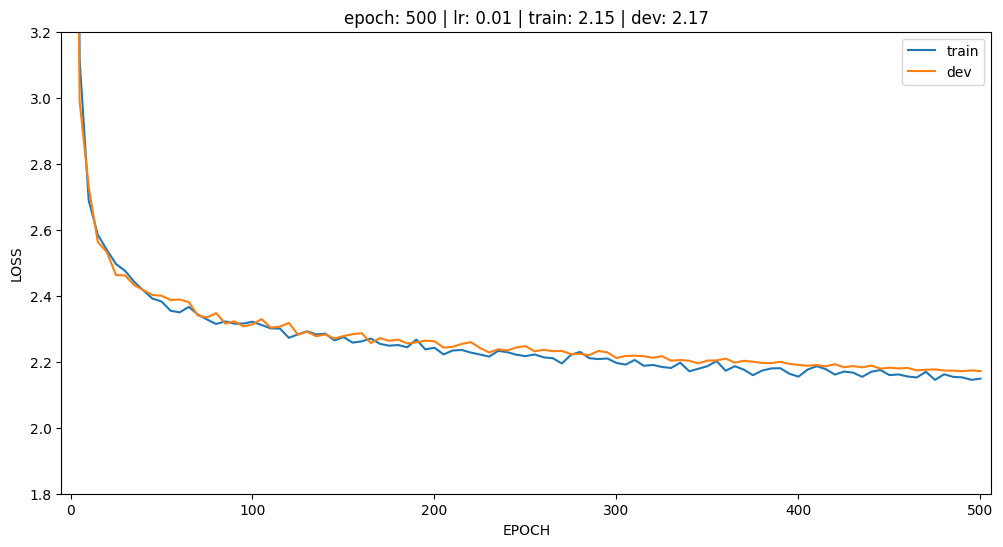

In [12]:
plt.ion()
fig, ax, l1, l2 = do_plot()

for epoch in range(epochs):
  bloss = 0.0
  for i, (inputs, targets) in enumerate(train_dl):
    # forward pass
    loss = do_loss(inputs, targets)
    bloss += loss.item()

    # backward pass
    for p in parameters: p.grad = None
    loss.backward()
    
    # update
    lr = lrs[epoch]
    for p in parameters: p.data -= lr * p.grad

    if i >= batches_cut: break

  # printout
  if epoch % 5 == 0:
    epochs_list.append(epoch)
    train_losses.append(bloss/batches_cut)
    dev_losses.append(do_loss(Xdev, Ydev).item())
    update_plot(f"epoch: {epoch:3d} | lr: {lr:.2f} | train: {train_losses[-1]:.2f} | dev: {dev_losses[-1]:.2f}")

plt.ioff()

In [13]:
# _ = do_plot()

In [14]:
# sample from the model
torch.manual_seed(42)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      inputs = torch.tensor([context])
      logits = model(inputs)
      probs = logits.softmax(1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))

anueelyn.
jamarbi.
nehan.
shan.
silaylen.
kemarce.
man.
epiacelle.
jamzi.
kence.
jordin.
kalla.
mikhlynn.
acvilia.
aczalani.
nar.
tiyan.
mar.
tal.
selvio.


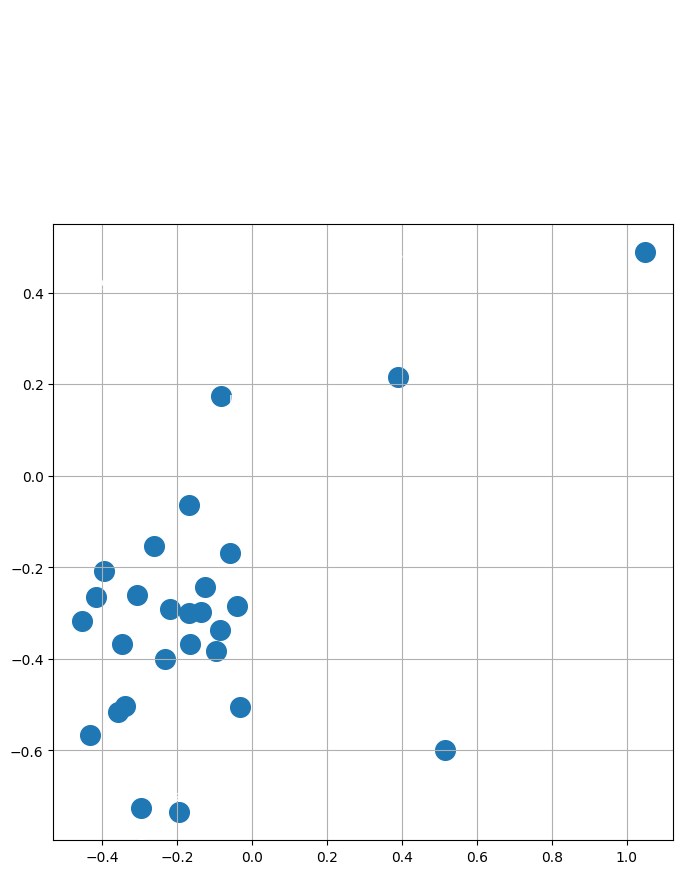

In [15]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()